# PyTorch Computational Graph and Automatic Differentiation
We use data models to fit unknown functions of which we have a set of samples. The data model is built from functions that we choose because we think they can represent the real unknown function after we have set their parameters using the set of samples. The procedure to find the right paramneter values is always the same: we define a loss function, e.g. the mean squared error, to be minimized using the backpropagation algorithm. The data model can be as simple as a linear function, i.e. $y = ax + b$, with only the two parameters a,b or much more complex like a deep learning model where the data model is represented by a set of nested parametric functions that are a combination of affine transformations and nonlinear activation functions. The backpropagation algorithm requires the computation of the gradient of the loss function that becomes quicky difficult as soon as we raise the complexity of our model. In this notebook we will see how we can train our model with PyTorch overcoming the difficulties of computing the backpropagation algorithm using its computational graph and automatic differentiation.   

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import torch
import torch.nn as nn
warnings.filterwarnings('ignore')
print("NumPy version: %s"%np.__version__)
print("Pandas version: %s"%pd.__version__)
print("PyTorch version: %s"%torch.__version__)

NumPy version: 1.23.1
Pandas version: 1.4.3
PyTorch version: 1.13.0


## Computational graph
We build a graph for a very simple computation: 

$$s = 2 * (x - y) + z$$

The computational graph is a directed acyclic graph that can be built from operators such as sub(), mul(), add() that implement the arithmetic operations on scalars: subtraction, multiplication, addition. 

In [3]:
def compute_s(x, y, z):
    r1 = torch.sub(x, y)
    r2 = torch.mul(r1, 2)
    z = torch.add(r2, z)
    return z

We assign a value to the variables that are represented as tensors of rank 0 and then we compute the value of the dependent variable s

In [4]:
x = torch.tensor(1)
y = torch.tensor(2)
z = torch.tensor(5)
s = compute_s(x, y, z)
print('s =', s)       

s = tensor(3)


In [5]:
torch.manual_seed(1)
w = torch.empty(2, 3)
nn.init.xavier_normal_(w)
print(w)

tensor([[ 0.4183,  0.1688,  0.0390],
        [ 0.3930, -0.2858, -0.1051]])


## Backpropagation and autodifferentiation
A deep learning model is a parametric model of nested functions, e.g. y = f(g(h(x))), that we use to fit an unknown function $\hat{y}$ of which we have a number N of sample data points, like a function that maps a picture of a cat to its label "cat". Fitting this type of models is not different conceptually from fitting a linear model such as y = ax + b. In this simple case we have only two parameters a, b, that we want to find using a set of examples. The procedure is to define a loss function, e.g. 

$$\mathscr{L} = \frac{1}{2} \sum_{i=1}^N|| y - \hat{y_i}||^2$$ 

that we want to minimize by updating the parameters a, b till the loss is as close to zero as possible. The same idea is used also for a deep neural network model. We have a model built from nested parametric nonlinear functions for which we know the form (a combination of affine transformations and well known activation functions) but not the right parameters so the procedure is again to write a loss function to be minimized by updating the model's parameters $w$ using a set of examples and the backpropagation algorithm

$$w_{j+1} = w_j - \gamma \nabla_w{\mathscr{L}}$$

where

$$\nabla_w{\mathscr{L}} = ||y - \hat{y}|| \frac{\partial{y}}{\partial{w}}$$

Clearly the y function must be differentiable if we want to compute its gradient, that is its partial derivatives with respect to the parameters $w$. In case of a simple model we could write the equations to compute the derivatives numerically or by symbolic substitution and the chain rule known from Calculus. The problem is that with deep neural networks with thousands or millions of parameters this procedure would be unfeasible and numerically unstable. A better technique is computing the derivatives of the y function with respect to the model parameters using the computational graph that is built with the model. When we define a model PyTorch builds the corresponding computational graph. In order to compute the derivatives with respect to a paramenter we have to tell PyTorch which parameters require the derivative (or the gradient if it is an array). 

As an example we will build a linear model $y = ax + b$. We can draw our model's computational graph starting from the leaves, that is the two parameters a and b and one data point (x1, y1). We assign the initial values to our parameters. These values will be updated in the training process using the data points and the backpropagation algorithm. What is important to know here is that PyTorch requires the parameters to be enabled for automatic differentiation by setting the attribute requires_grad to true.   

In [6]:
a = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(0.5, requires_grad=True) 

In our simple linear case the loss function is a quadratic function of the two parameters a and b and that means it is also a convex function with only one minimum so that it will be quite easy for the backpropagation algorithm to find

$$\mathscr{L} = \frac{1}{2} \sum_{i=1}^N|| ax + b - \hat{y_i}||^2$$ 

The partial derivatives of the loss must be evaluated at the data points, in our case at (x1, y1)

$$\frac{\partial{\mathscr{L}}}{\partial{a}} = (y - \hat{y}) \frac{\partial{y}}{\partial{a}} = (ax + b - \hat{y})x$$

$$\frac{\partial{\mathscr{L}}}{\partial{b}} = (y - \hat{y}) \frac{\partial{y}}{\partial{b}} = ax + b -\hat{y}$$

We will use only one data point to compute the loss and its gradient

In [7]:
x1 = torch.tensor([1.4])
y1 = torch.tensor([2.1])

We can easily define our linear model, using the PyTorch functions mul() for multiplication, and add() for addition, and compute our model prediction for the data point x1  

In [8]:
y = torch.add(torch.mul(a, x1), b)
y

tensor([1.9000], grad_fn=<AddBackward0>)

Since the loss function is built from differentiable parameters we can compute its gradient using the backward() method available to all PyTorch tensors

In [9]:
loss = 0.5 * (y - y1).pow(2).sum()
loss.backward()

We can print the value of the partial derivatives of the loss function with respect to the parameters a and b. These values will be used to update the value of the paramenters in order to reduce the loss

In [10]:
print('dL/da : ', a.grad)
print('dL/db : ', b.grad)

dL/da :  tensor(-0.2800)
dL/db :  tensor(-0.2000)


we can compute manually the partial derivative of the loss with respect to the parameter a to see that it matches with the result computed by PyTorch via automatic differentiation

In [11]:
x1*(a*x1 + b - y1)

tensor([-0.2800], grad_fn=<MulBackward0>)

## Sequential models
PyTorch allows the implementation of neural networs based on a sequence of layers in which the output of one layer is the input of the next one. PyTorch provides the [Sequential](https://pytorch.org/docs/master/generated/torch.nn.Sequential.html) container and several layers to build different types of architectures. One of the most common architecture is the feedforward neural network that is composed of a sequence of blocks of a [linear layer](https://pytorch.org/docs/master/generated/torch.nn.Linear.html) and a [nonlinear activation function](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity). A linear layer implements an affine transformation and is created by specifying the number $n$ of inputs and a number $m$ of outputs, that is the number of units in the layer. The coupling between the inputs and the outputs can be represented by a matrix of weights of rank $nm$. In the following example we build a small neural network of two blocks of a linear layer and an activation function ([ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)). The NN has two linear layers, an input layer with 4 inputs and 16 units and an hidden layer with 16 inputs and 32 units. 

In [12]:
model = nn.Sequential(
    nn.Linear(4, 16),
    nn.ReLU(),
    nn.Linear(16, 32),
    nn.ReLU()
)

model

Sequential(
  (0): Linear(in_features=4, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=32, bias=True)
  (3): ReLU()
)

Now we build a data set, for a classification task, that cannot be separated by a linear function to see what is the performance of different networks in this task 

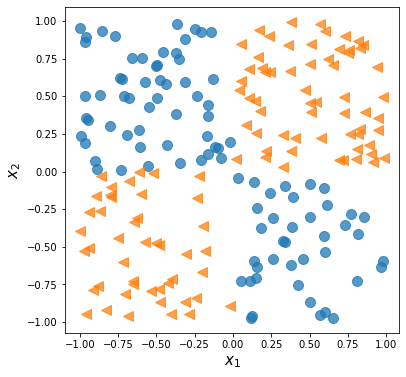

In [13]:
np.random.seed(1)
torch.manual_seed(1)
x = np.random.uniform(low=-1, high=1, size=(200, 2))
y = np.ones(len(x))
y[x[:, 0] * x[:, 1]<0] = 0

n_train = 100
x_train = torch.tensor(x[:n_train, :], dtype=torch.float32)
y_train = torch.tensor(y[:n_train], dtype=torch.float32)
x_valid = torch.tensor(x[n_train:, :], dtype=torch.float32)
y_valid = torch.tensor(y[n_train:], dtype=torch.float32)

fig = plt.figure(figsize=(6, 6))
plt.plot(x[y==0, 0], x[y==0, 1], 'o', alpha=0.75, markersize=10)
plt.plot(x[y==1, 0], x[y==1, 1], '<', alpha=0.75, markersize=10)
plt.xlabel(r'$x_1$', size=15)
plt.ylabel(r'$x_2$', size=15)

plt.show()

As we discussed in a previous notebook we have to create a Dataset and a DataLoader to train our model with PyTorch

In [14]:
from torch.utils.data import DataLoader, TensorDataset
 
train_ds = TensorDataset(x_train, y_train)
batch_size = 2
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

The next step is to design a model, starting from a simple one for example with only a layer of two inputs and one output. We will see that such a model will not be able to perform well on our data set so we will come back to this point to increase the network capacity or by adding more units to our layer or by adding new layers to see whether out model's performance improves.

In [15]:
model = nn.Sequential(
    ## nn.Linear(2, 1),
    ## nn.Sigmoid()
    nn.Linear(2, 4),
    nn.ReLU(),
    nn.Linear(4, 4),
    nn.ReLU(),
    nn.Linear(4, 1),
    nn.Sigmoid()
)

model

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
  (5): Sigmoid()
)

We select the loss function for binary classification ([BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)) and the optimization algorithm (Stochastic Gradient Descent) and its learning rate

In [16]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)

Now we are ready to start the training loop

In [17]:
torch.manual_seed(1)
num_epochs = 200
def train(model, num_epochs, train_dl, x_valid, y_valid):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.mean()

        loss_hist_train[epoch] /= n_train/batch_size
        accuracy_hist_train[epoch] /= n_train/batch_size

        pred = model(x_valid)[:, 0]
        loss = loss_fn(pred, y_valid)
        loss_hist_valid[epoch] = loss.item()
        is_correct = ((pred>=0.5).float() == y_valid).float()
        accuracy_hist_valid[epoch] += is_correct.mean()
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

history = train(model, num_epochs, train_dl, x_valid, y_valid)

We can track the evolution of the training loss and the validation loss at each epoch and each time we change the network 

Text(0.5, 0, 'Epochs')

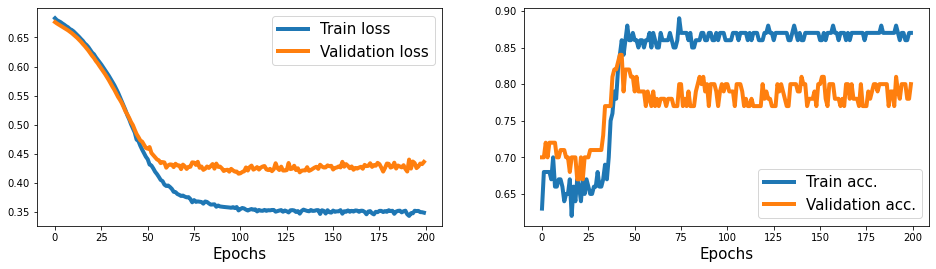

In [18]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

## Building more flexible models
The Sequential container allows us to build standard feedforward model with as many layers we need but it doesn't allows us to build nonsequential models. For a more flexible architecture we can use PyTorch [nn.Module](https://pytorch.org/docs/master/generated/torch.nn.Module.html). In case we need a more complex architecture than what we can build with the Sequential container we can create a subclass of nn.Module and implement its constructor init() and its forward() method. The constructor is used to define the model's architecture and the forward method is used to specify how the input data will go through all the model's layers to be finally returned as output. 

In [19]:
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        l1 = nn.Linear(2, 4)
        a1 = nn.ReLU()
        l2 = nn.Linear(4, 4)
        a2 = nn.ReLU()
        l3 = nn.Linear(4, 1)
        a3 = nn.Sigmoid()
        l = [l1, a1, l2, a2, l3, a3]
        self.module_list = nn.ModuleList(l)

    def forward(self, x):
        for f in self.module_list:
            x = f(x)
        return x
    
    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred>=0.5).float()
            
model = MyModule()
model

MyModule(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

We will use our new model for the same classification task we saw before and we will also use the same loss function and optimization algorithm. The training loop is also the same

In [20]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)
history = train(model, num_epochs, train_dl, x_valid, y_valid)

Text(0.5, 0, 'Epochs')

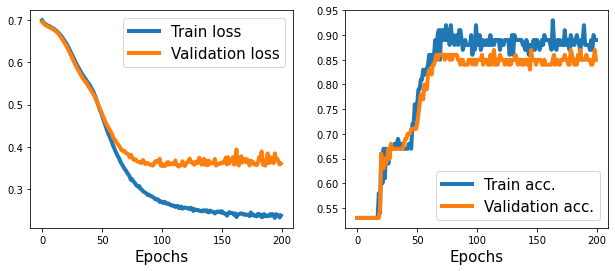

In [21]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

In [22]:
#conda install -c conda-forge mlxtend 

**!!The plotting function doesn't seem to work properly**

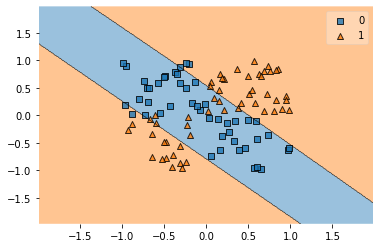

In [28]:
#from mlxtend.plotting import decision_regions
from mlxtend.plotting.decision_regions import plot_decision_regions

ax = fig.add_subplot(1, 1, 1)
plot_decision_regions(X = x_valid.numpy(), y = y_valid.numpy().astype(np.int64), clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()